<a href="https://colab.research.google.com/github/kenawnurum/kenaw-portfolio/blob/main/SentimentAnalysisA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SentimentRNN(
  (embedding): Embedding(1193514, 200)
  (rnn): RNN(200, 25, batch_first=True)
  (fc): Linear(in_features=25, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch 1, Loss: 0.2675
Epoch 2, Loss: 0.2590
Epoch 3, Loss: 0.2589
Epoch 4, Loss: 0.2587
Epoch 5, Loss: 0.2587
Epoch 6, Loss: 0.2590
Epoch 7, Loss: 0.2589
Epoch 8, Loss: 0.2586
Epoch 9, Loss: 0.2588
Epoch 10, Loss: 0.2588
Train Accuracy: 0.9282
Precision: 1.0000
Recall: 0.0000
F1 Score: 0.0000

Classification Report:
              precision    recall  f1-score   support

    Negative       0.93      1.00      0.96      5198
    Positive       0.00      0.00      0.00       402

    accuracy                           0.93      5600
   macro avg       0.46      0.50      0.48      5600
weighted avg       0.86      0.93      0.89      5600



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


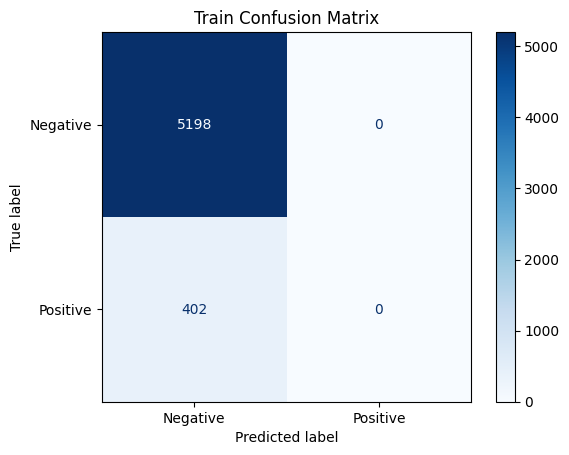

Test Accuracy: 0.9407
Precision: 1.0000
Recall: 0.0000
F1 Score: 0.0000

Classification Report:
              precision    recall  f1-score   support

    Negative       0.94      1.00      0.97      1317
    Positive       0.00      0.00      0.00        83

    accuracy                           0.94      1400
   macro avg       0.47      0.50      0.48      1400
weighted avg       0.88      0.94      0.91      1400



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


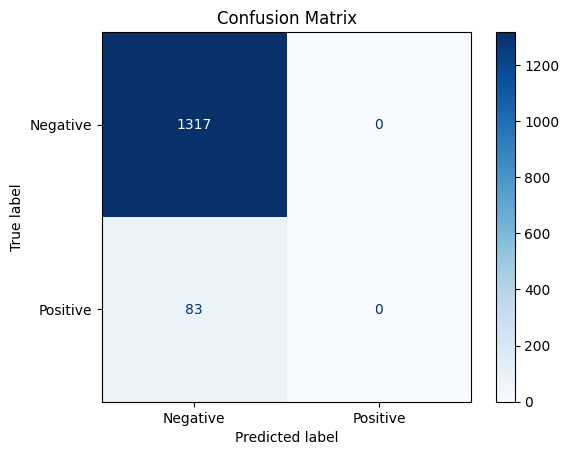

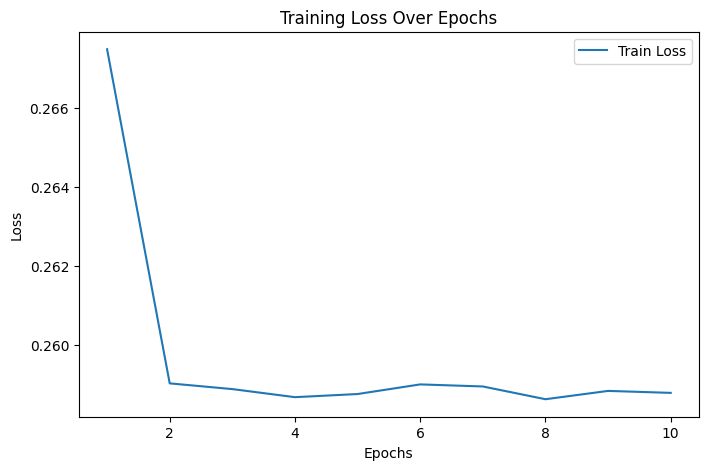

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import GloVe
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Define dataset class
class SentimentDataset(Dataset):
    def __init__(self, df, vocab, tokenizer, max_len=50):
        self.texts = df['tweet'].tolist()
        self.labels = [1 if label == "Positive" else 0 for label in df['sentiment']]
        self.tokenizer = tokenizer
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokens = self.tokenizer(self.texts[idx])
        # Use vocab.stoi to get the index of each token
        indices = [self.vocab.stoi[token] for token in tokens if token in self.vocab.stoi]
        indices = indices[:self.max_len] + [0] * (self.max_len - len(indices))
        return torch.tensor(indices, dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.float)
# Load GloVe embeddings
tokenizer = get_tokenizer("basic_english")
vocab = GloVe(name='twitter.27B', dim=200)

# Prepare datasets and loaders
train_dataset = SentimentDataset(train_df, vocab, tokenizer)
test_dataset = SentimentDataset(test_df, vocab, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)

# Define RNN model
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(SentimentRNN, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(vocab.vectors, freeze=False)
        #self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
       # self.fc = nn.Linear(hidden_dim*2, 1)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)  # Adjust for bidirectionality

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, h_n = self.rnn(x)
        out = self.fc(h_n.squeeze(0))
        return self.sigmoid(out)

# Model setup
model = SentimentRNN(len(vocab.stoi), 200, 25).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Print model architecture
print(model)

# Training loop
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    train_losses = []
    for epoch in range(epochs):
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            labels = labels.squeeze()  # match dimension
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")
    return train_losses

# Train the model
train_losses = train_model(model, train_loader, criterion, optimizer)
train_accuracy = evaluate_train_model(model, train_loader)

# Evaluation with confusion matrix and metrics
def evaluate_train_model(model, train_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            predictions = (outputs >= 0.5).float()
            y_true.extend(labels.squeeze().cpu().tolist())
            y_pred.extend(predictions.cpu().tolist())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    accuracy = (y_true == y_pred).sum() / len(y_true)
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred, zero_division=1)
    f1 = f1_score(y_true, y_pred, zero_division=1)

    print(f"Train Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}\n")
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Train Confusion Matrix")
    plt.show()

    return accuracy

# Evaluate the model with detailed metrics
test_accuracy = evaluate_model(model, test_loader)

# Plot training loss
plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()
